# TODO

- performance benchmark:
    - GP
    - GP + kernel opt na kazdy kernel
    - BO

- ~~noisy~~
- ~~optimalizace diskretnich hyperparam - https://arxiv.org/pdf/1706.03673.pdf~~

- benchmark + proc approx?
- ~~paralelni EI~~
- expected imrpovement per second (vetsi hyperaram me stoji vic trenovani)
- v prubehu zjistim ze se mi to nelibi

- ~~kernely~~
- acquisition funkce

- ~~matern kernel wtf???~~
- ~~zkusit jestli torch.lbfgs je rychlejsi?~~

- stable eye vypnout
- funkce, merit nejlepsi kernel, ranky
- proc hyperparam opt kernelu nedojdou k stejnymu min (proc vubec vadi scaling?), tolerance
- jak moc paralelismus ovlivnuje
- rezy v nejlepsim vysledku bopt (marginal?)
- priory na parametry
- knowledge gradient, a dalsi???

- acquisition function heatmap

- podivat se na http://hyperopt.github.io/hyperopt/

In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np
import random
import matplotlib.pyplot as plt

from numpy.linalg import solve, cholesky, inv
from numpy.random import multivariate_normal

from functools import partial

%matplotlib inline

from myopt.kernel_opt import plot_kernel_loss
from myopt.kernels import SquaredExp, RationalQuadratic, Linear, Matern
from myopt.gaussian_process import GaussianProcess, compute_optimized_kernel
from myopt.bayesian_optimization import bo_plot_exploration, bo_maximize, Integer, Float
from myopt.bayesian_optimization import plot_2d_optim_result, bo_maximize_parallel, bo_plot_exploration_parallel
from myopt.acquisition_functions import expected_improvement, probability_of_improvement
from myopt.bayesian_optimization import propose_location
from myopt.opt_functions import get_opt_test_functions
import concurrent

In the basic form we have $K = k(X_{\text{train}}, X_{\text{train}}), K_* = k(X_{\text{train}}, X_{\text{test}}), K_{**} = k(X_{\text{test}}, X_{\text{test}})$, which gives us the following posterior

$$
\begin{align}
    \mu &= K_* K^{-1} y \\
    var &= K_{**} - K_* K^{-1} K_*^T.
\end{align}
$$

We can also write

$$
\begin{align}
    L &= cholesky(K) \\
    \alpha &= L^T \backslash (L \backslash y) \\
    \mu &= K_*^T \alpha \\
    v &= L \backslash K_* \\
    var &= K_{**} - v^T v,
\end{align}
$$

and we also know that

$$
(L \backslash K_*)^T (L \backslash y) = K_*^T (L^T \backslash (L \backslash y)) = K_* K^{-1} y
$$

## GP regression (ignoring noisy for now)

We condition on the training data and compute the posterior for the test data $X_{\text{test}}$. Since the posterior is Gaussian, it is fully defined by its mean and covariance, which we can compute in closed form

$$
\begin{align}
    \mu_* &= K_*^T K^{-1} y \\
    \Sigma_* &= K_{**} - K_*^T K^{-1} K_*
\end{align}
$$

More tricks with Cholesky

$$
\begin{align}
L &= cholesky(K) \\
L_k &= L \backslash K_s \\
\mu &= L_k^T (L \backslash y) \\
	&= (L \backslash K_s)^T (L \backslash y) \\
	&= (L^{-1} K_s)^T (L^{-1} y) \\
	&= K_s^T (L^{-1})^T L^{-1} y \\
	&= K_s^T K^{-1} y
\end{align}
$$

## Big data (:

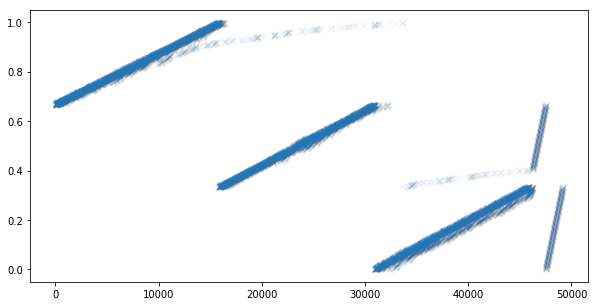

In [8]:
values = np.genfromtxt("data/matmul_faults.txt", converters={0:lambda s: int(s, 16)}, dtype=np.int64)
from sklearn.preprocessing import MinMaxScaler
values = MinMaxScaler().fit_transform(values.reshape(-1, 1).astype(np.float64))

plt.figure(figsize=(10,5))
plt.plot(values, "x", alpha=0.01)

In [9]:
offset = 0
num = 500
X = np.array(list(range(len(values))))[offset:offset + num]
y = values[offset:offset + num].reshape(-1)

y = MinMaxScaler().fit_transform(y.reshape(-1,1).astype(np.float64)).reshape(-1)
X = np.array(list(range(len(y))))

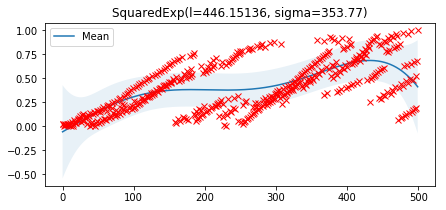

In [10]:
y = MinMaxScaler().fit_transform(y.reshape(-1,1).astype(np.float64)).reshape(-1)
X = np.array(list(range(len(y))))

gp = GaussianProcess(kernel=SquaredExp(), noise=1).fit(X, y).optimize_kernel().posterior(X)
gp.plot_posterior(num_samples=0)

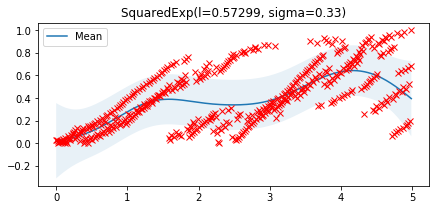

In [11]:
y = MinMaxScaler().fit_transform(y.reshape(-1,1).astype(np.float64)).reshape(-1)
X = np.array(list(range(len(y))))/100

gp = GaussianProcess(kernel=SquaredExp(), noise=1).fit(X, y).optimize_kernel().posterior(X)
gp.plot_posterior(num_samples=0)

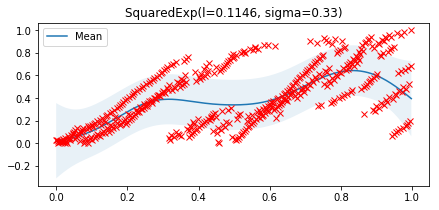

In [12]:
y = MinMaxScaler().fit_transform(y.reshape(-1,1).astype(np.float64)).reshape(-1)
X = np.array(list(range(len(y))))/500

gp = GaussianProcess(kernel=SquaredExp(), noise=1).fit(X, y).optimize_kernel().posterior(X)
gp.plot_posterior(num_samples=0)

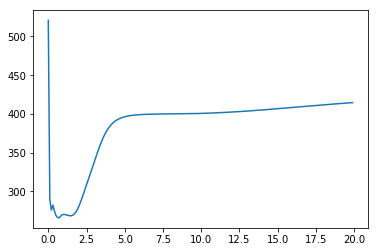

In [13]:
offset = 0
num = 500
X = np.array(list(range(len(values))))[offset:offset + num]
y = values[offset:offset + num].reshape(-1)

y = MinMaxScaler().fit_transform(y.reshape(-1,1).astype(np.float64)).reshape(-1)
X = np.array(list(range(len(y))))/100

plot_kernel_loss(SquaredExp(), X, y)

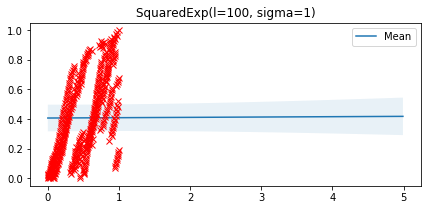

In [14]:
gp.with_kernel_params([100,1]).posterior(X).plot_posterior(num_samples=0)

## Kernel params with GPy

In [49]:
import GPy

In [50]:
kernel = GPy.kern.RBF(input_dim=1, variance=1., lengthscale=1.)

In [51]:
kernel = GPy.kern.Matern52(input_dim=1, variance=1., lengthscale=1.)

{'dataplot': [<matplotlib.collections.PathCollection at 0x7fe82c208cc0>],
 'gpmean': [[<matplotlib.lines.Line2D at 0x7fe82c208be0>]],
 'gpconfidence': [<matplotlib.collections.PolyCollection at 0x7fe82c212198>]}

 /home/darth/.venv/tf-gpu/lib/python3.6/site-packages/matplotlib/figure.py:2366: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


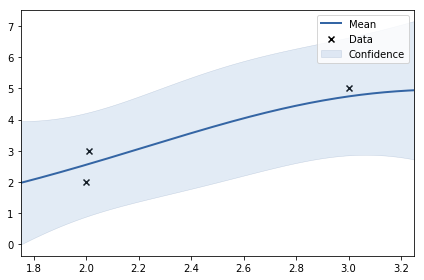

In [52]:
m = GPy.models.GPRegression(X_train.reshape(-1,1),y_train.reshape(-1, 1),kernel)
m.optimize(messages=True)
m.plot()

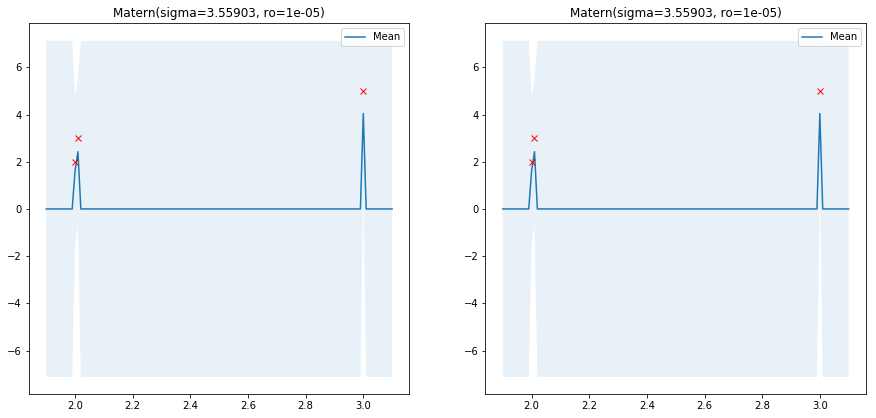

In [53]:
params = [0.1, 0.3]#, 0.6, 0.9]

#X_train = np.array([0, 0.02, 0.05, 0.3, 0.4,1,1.1,1.2,1.3,1.4,2,3,4])
X_train = np.array([2,2.01,3])#, 0.02, 0.05, 0.3, 0.4,1,2,3,4])
y_train = np.array([2,3,5])
# y_train[1] = .6
# y_train[2] = 1

X = np.arange(min(X_train) - 0.1, max(X_train) + 0.1, step=0.01)
gp = GaussianProcess(noise=3, kernel=Matern())

plt.figure(figsize=(15,15))
for i, l in enumerate(params):
    num_rows = len(params) // 2 + 1

    plt.subplot(num_rows, 2, i+1)
    
    gp.with_kernel_params([l, 1]).fit(X_train, y_train).optimize_kernel().posterior(X).plot_posterior(figure=False, num_samples=0)

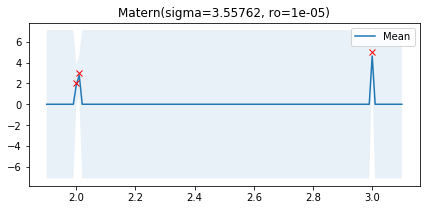

In [44]:
gp = GaussianProcess(noise=1, kernel=Matern()).fit(X_train, y_train).optimize_kernel().posterior(X).plot_posterior(num_samples=0)

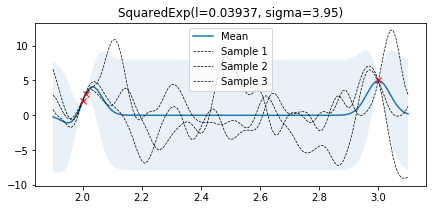

In [28]:
gp = GaussianProcess(noise=.01, kernel=SquaredExp()).fit(X_train, y_train).optimize_kernel().posterior(X).plot_posterior()

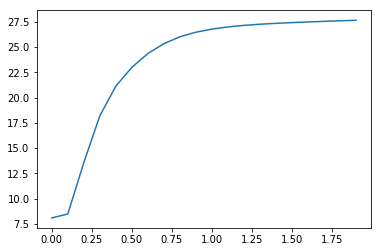

In [29]:
gp = GaussianProcess(noise=.01, kernel=SquaredExp()).fit(X_train, y_train).optimize_kernel()
plot_kernel_loss(gp.kernel, X_train, y_train, xmax=2)

In [20]:
gp.posterior(X_train).mu_std()

(array([0.50034335, 0.49921345, 0.49635505, 0.42048151, 0.36741499]),
 array([0.06073833, 0.05708556, 0.05316969, 0.06147667, 0.0793184 ]))

## Optimizing kernel parameters

$$
\begin{align}
    \log p(y|X) &= \log N(y|0, K_y) \\
                &= -\frac{1}{2} y^T K_y^{-1} y - \frac{1}{2} \log |K_y| - \frac{N}{2} \log(2 \pi)
\end{align}
$$

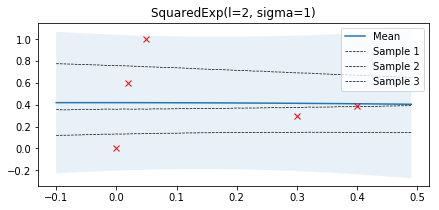

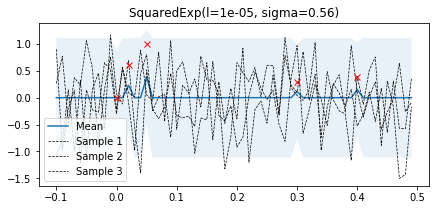

In [24]:
GaussianProcess(.5).fit(X_train, y_train)\
        .with_kernel_params([2, 1]).posterior(X).plot_posterior()\
        .optimize_kernel().posterior(X).plot_posterior()

# Bayesian Optimization

http://krasserm.github.io/2018/03/21/bayesian-optimization/

In [25]:
bounds = [Float(-1.0, 2.0)]
noise = 0.2

def f(X):
    return -np.sin(3*X) - X**2 + 0.7*X

X_init = np.array([[-0.9], [1.1]])
y_init = f(X_init)

# Dense grid of points within bounds
X_true = np.arange(bounds[0].low, bounds[0].high, 0.01).reshape(-1, 1)

# Noise-free objective function values at X 
y_true = f(X_true)

noisy_f = lambda x: f(x).item() + random.random()*0.01

In [26]:
bo_maximize(noisy_f, bounds)

100%|██████████| 7/7 [00:02<00:00,  3.50it/s]


OptimizationResult(best_x=[-0.40374833], best_y=0.49702935364672257)

100%|██████████| 7/7 [00:01<00:00,  5.65it/s]


OptimizationResult(best_x=[-0.35003195], best_y=0.505698887197115)

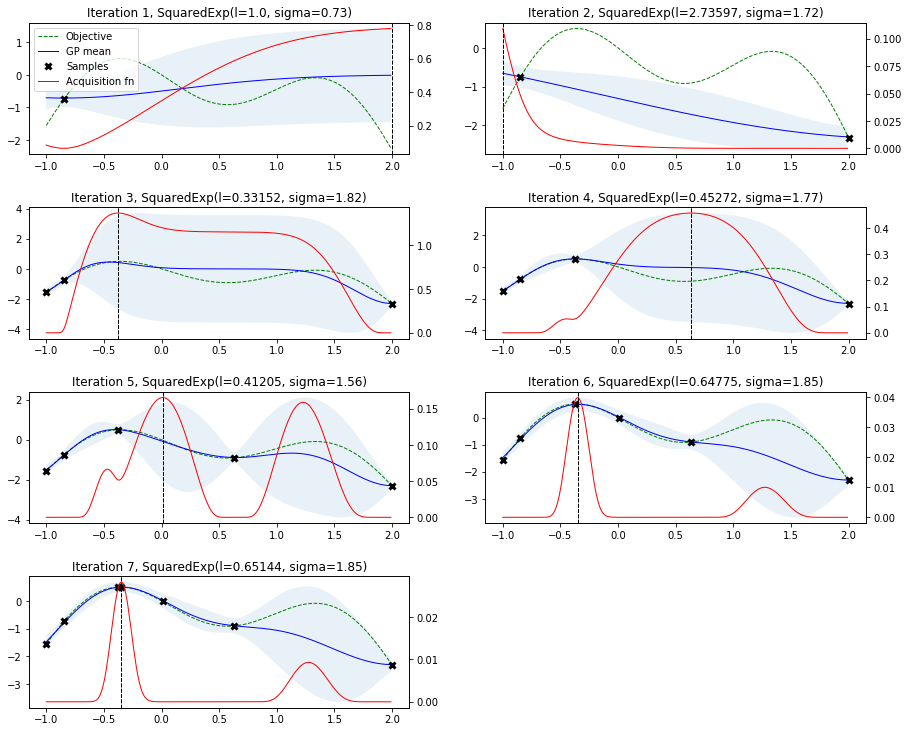

In [30]:
bo_plot_exploration(noisy_f, bounds, X_true=X_true, y_true=y_true, n_iter=8, gp_noise=0.02)

100%|██████████| 7/7 [00:01<00:00,  5.20it/s]


OptimizationResult(best_x=[1.36266336], best_y=-0.08432424631200454)

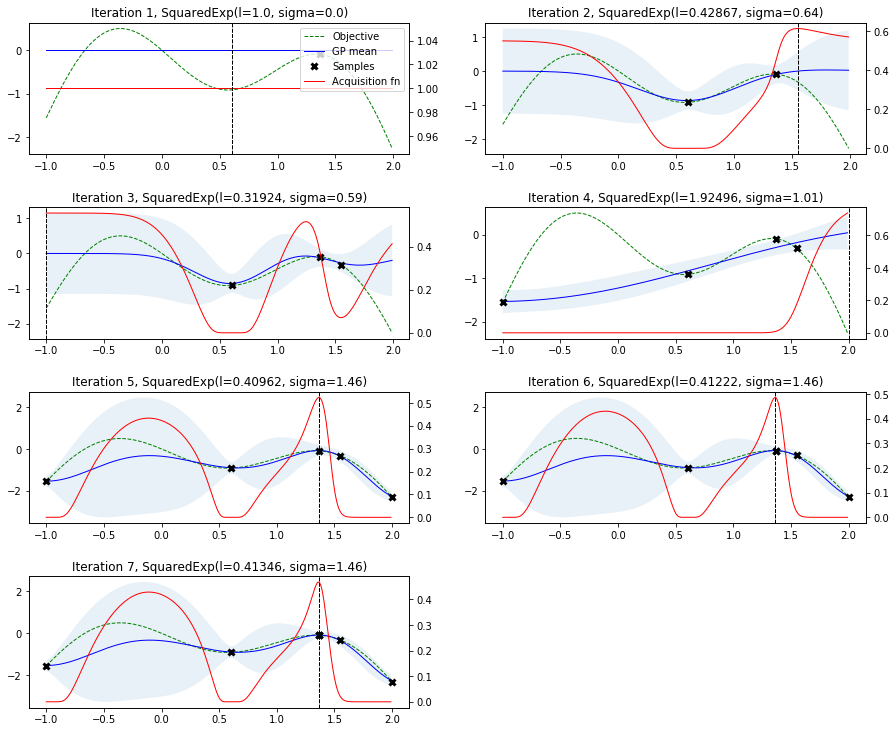

In [32]:
bo_plot_exploration(noisy_f, bounds, acquisition_function=probability_of_improvement,
                    X_true=X_true, y_true=y_true, n_iter=8, gp_noise=0.02)

## 2D bayes opt

In [38]:
optfun = get_opt_test_functions()[2]
optfun

<function myopt.opt_functions.eggholder(x:numpy.ndarray) -> float>

In [39]:
%prun bo_maximize(optfun, bounds=optfun.bounds, n_iter=27)

100%|██████████| 26/26 [00:13<00:00,  1.27it/s]

100%|██████████| 29/29 [01:24<00:00, 17.17s/it]


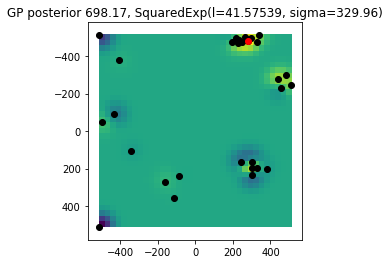

In [35]:
res = bo_maximize(optfun, bounds=optfun.bounds, n_iter=30)
plot_2d_optim_result(res)

In [41]:
def f(x):
    y = x[1] * 10
    x = x[0] * 10
    
    val = -(y + 47) * np.sin(np.sqrt(np.abs(x/2 + (y + 47)))) - x * np.sin(np.sqrt(np.abs(x - (y + 47))))
    return -val.item()

def ff(x):
    return np.sin(np.linalg.norm(x)).item()


# bounds = [Integer(-5, 8), Float(-2, 3), Float(0, 10), Integer(2, 10), Float(-2, 3), Float(0, 10), Integer(2, 10), Float(-2, 3), Float(0, 10), Integer(2, 10)]
bounds = [Float(-5, 5), Float(-10, 5)]

res = bo_maximize(f, bounds, n_iter=30, kernel=SquaredExp())

100%|██████████| 29/29 [00:15<00:00,  1.11it/s]


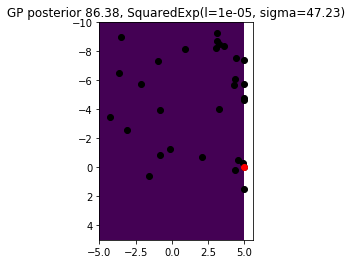

In [42]:
plot_2d_optim_result(res)

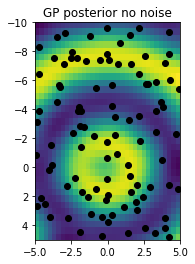

In [43]:
bounds = [Float(-5, 5), Float(-10, 5)]

from myopt.plot import plot_gp_2D
from mpl_toolkits.mplot3d import axes3d, Axes3D

noise_2d = 0.01

rx, ry = np.arange(-5, 5, 0.3), np.arange(-10, 5, 0.45)
gx, gy = np.meshgrid(rx, ry)

X_2d = np.c_[gx.ravel(), gy.ravel()]

X_2d_train = np.array([np.array([bound.sample() for bound in bounds]) for _ in range(100)])
# X_2d_train = np.random.uniform(-4, 4, (200, 2))
y_2d_train = np.sin(np.linalg.norm(X_2d_train, axis=1))# + noise_2d * np.random.randn(len(X_2d_train))

mu_s, _ = GaussianProcess(noise=0).fit(X_2d_train, y_2d_train).optimize_kernel().posterior(X_2d).mu_std()

b1=bounds[0]
b2 = bounds[1]

plt.figure(figsize=(12, 4))
plt.subplot(131); plt.title("GP posterior no noise");
plt.scatter(X_2d_train[:,0], X_2d_train[:,1], c="k")
plt.imshow(mu_s.reshape(gx.shape[0], gy.shape[0]), extent=[b1.low, b1.high, b2.high, b2.low])

gp = GaussianProcess(noise=0.01).fit(X_2d_train, y_2d_train).optimize_kernel().posterior(X_2d)
mu_s, _ = gp.mu_std()

100%|██████████| 149/149 [05:32<00:00,  4.57s/it]


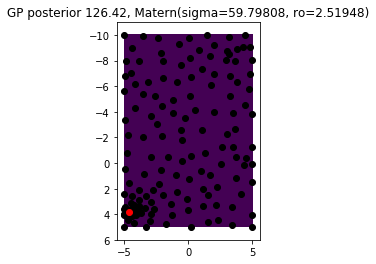

In [45]:
res = bo_maximize(f, bounds, n_iter=150, kernel=Matern(), gp_noise=0.05)
plot_2d_optim_result(res)

In [ ]:
plt.figure(figsize=(15,17))
results = []
for i in range(12):    
#     res = bo_maximize_parallel(parallel_f, bounds, n_iter=25, kernel=Matern() if i < 6 else SquaredExp(), gp_noise=0.05, n_parallel=5)
    res = bo_minimize(f, bounds, n_iter=25, kernel=Matern() if i < 6 else SquaredExp(), gp_noise=0.05, optimize_kernel=False)
    results.append(res)
    plt.subplot(4,3,i+1)
    plot_2d_optim_result(res)

In [ ]:
plt.figure(figsize=(15,17))
results = []
for i in range(12):    
#     res = bo_maximize_parallel(parallel_f, bounds, n_iter=25, kernel=Matern() if i < 6 else SquaredExp(), gp_noise=0.05, n_parallel=5)
    res = bo_maximize(f, bounds, n_iter=25, kernel=Matern() if i < 6 else SquaredExp(), gp_noise=0.05)
    results.append(res)
    plt.subplot(4,3,i+1)
    plot_2d_optim_result(res)

In [ ]:
res

In [ ]:
def f(x):
    return np.sin(np.linalg.norm(x)).item()

def parallel_f(x):
    return executor.submit(f, x)

def f(x):
    y = x[1]
    x = x[0]
    
    val = -(y + 47) * np.sin(np.sqrt(np.abs(x/2 + (y + 47)))) - x * np.sin(np.sqrt(np.abs(x - (y + 47))))
    return -val.item()

def parallel_f(x):
    return executor.submit(f, x)


bounds = [Float(-512, 512), Float(-512, 512)]

plt.figure(figsize=(10,7))
res = bo_maximize_parallel(parallel_f, bounds, n_iter=50, kernel=Matern(), gp_noise=0.05, n_parallel=2)
results.append(res)
plot_2d_optim_result(res, resolution=25)

In [ ]:
from myopt.plot import plot_gp_2D
from mpl_toolkits.mplot3d import axes3d, Axes3D

noise_2d = 0.01

rx, ry = np.arange(-5, 5, 0.3), np.arange(-5, 5, 0.3)
gx, gy = np.meshgrid(rx, rx)

X_2d = np.c_[gx.ravel(), gy.ravel()]

X_2d_train = np.random.uniform(-4, 4, (200, 2))
y_2d_train = np.sin(0.5 * np.linalg.norm(X_2d_train, axis=1))# + noise_2d * np.random.randn(len(X_2d_train))

mu_s, _ = GaussianProcess(noise=0).fit(X_2d_train, y_2d_train).optimize_kernel().posterior(X_2d).mu_std()

plt.figure(figsize=(12, 4))
plt.subplot(131); plt.title("GP posterior no noise");
plt.imshow(mu_s.reshape(gx.shape[0], gy.shape[0]))

gp = GaussianProcess(noise=0.01).fit(X_2d_train, y_2d_train).optimize_kernel().posterior(X_2d)
mu_s, _ = gp.mu_std()

plt.figure(figsize=(12, 4))
plt.subplot(132); plt.title("GP posterior noise=0.1");
plt.imshow(mu_s.reshape(gx.shape[0], gy.shape[0]))


plt.subplot(133); plt.title("True F");
plt.imshow(np.sin(0.5 * np.linalg.norm(X_2d, axis=1)).reshape(gx.shape[0], gy.shape[0]))

In [ ]:
gp.posterior(np.array([[0,2]])).mu_std()

In [ ]:
from myopt.plot import plot_gp_2D
from mpl_toolkits.mplot3d import axes3d, Axes3D

noise_2d = 0.01

rx, ry = np.arange(-5, 5, 0.3), np.arange(-5, 5, 0.3)
gx, gy = np.meshgrid(rx, rx)

X_2d = np.c_[gx.ravel(), gy.ravel()]

X_2d_train = np.random.uniform(-4, 4, (50, 2))
y_2d_train = np.sin(0.5 * np.linalg.norm(X_2d_train, axis=1))# + noise_2d * np.random.randn(len(X_2d_train))

mu_s, _ = GaussianProcess(noise=0.01).fit(X_2d_train, y_2d_train).optimize_kernel().posterior(X_2d).mu_std()

plt.figure(figsize=(13,8))
plot_gp_2D(gx, gy, mu_s, X_2d_train, y_2d_train, "w/ kernel optt", 1)

plt.figure(figsize=(12, 4))
plt.subplot(121); plt.title("GP posterior"); plt.imshow(mu_s.reshape(gx.shape[0], gy.shape[0]))
plt.subplot(122); plt.title("True F"); plt.imshow(np.sin(0.5 * np.linalg.norm(X_2d, axis=1)).reshape(gx.shape[0], gy.shape[0]))
